In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import shap
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm


RANDOM_SEED = 42
MAX_LEN = 128 
BATCH_SIZE = 16
NUM_EPOCHS = 1
BERT_MODEL_NAME = 'bert-base-uncased'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


 PHASE 1: DATA ACQUISITION, CONSOLIDATION, AND PREPROCESSING 


In [ ]:
try:
    df_true = pd.read_csv('data/True.csv')
    df_fake = pd.read_csv('data/Fake.csv')

except FileNotFoundError:
    data_true = {
        'title': ['True Headline 1: A political report', 'True Headline 2: Science discovery details'],
        'text': ['This comprehensive article contains verified facts and direct quotes from officials. The context is clear.', 'The reliable source confirms the event date and location with high precision. Further evidence is provided.'],
        'subject': ['politics', 'science'],
        'date': ['Dec 1, 2020', 'Jan 5, 2021']
    }
    data_fake = {
        'title': ['Fake Headline 1!!! SHOCKER', 'Shocking Claim Exposed: You Won\'t Believe It'],
        'text': ['You won\'t believe this secret that the government is trying to hide from the public. Read this now before it\'s gone!', 'Experts say otherwise, but this article reveals the absolute truth. It is a conspiracy, folks. Very, very bad.'],
        'subject': ['conspiracy', 'politics'],
        'date': ['Dec 1, 2020', 'Jan 5, 2021']
    }
    df_true = pd.DataFrame(data_true)
    df_fake = pd.DataFrame(data_fake)

df_true['label'] = 0
df_fake['label'] = 1

df_combined = pd.concat([df_true, df_fake], ignore_index=True)
df_combined = df_combined.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

print(f"Combined dataset created with {len(df_combined)} entries.")


Combined dataset created with 44898 entries.


In [12]:
df_combined['title'] = df_combined['title'].fillna('')
df_combined['text'] = df_combined['text'].fillna('')

df_combined['full_text'] = df_combined['title'] + " " + df_combined['text']

df = df_combined.drop(columns=['title', 'text', 'subject', 'date'])

print(df.head())

   label                                          full_text
0      1   BREAKING: GOP Chairman Grassley Has Had Enoug...
1      1   Failed GOP Candidates Remembered In Hilarious...
2      1   Mike Pence’s New DC Neighbors Are HILARIOUSLY...
3      0  California AG pledges to defend birth control ...
4      1  AZ RANCHERS Living On US-Mexico Border Destroy...


In [14]:
df_train, df_temp = train_test_split(
    df, test_size=0.2, random_state=RANDOM_SEED, stratify=df['label']
)

df_val, df_test = train_test_split(
    df_temp, test_size=0.5, random_state=RANDOM_SEED, stratify=df_temp['label']
)

print(f"\n Data Split Summary ")
print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")
print(f"\nLabel distribution in Training set (0=True, 1=Fake):\n{df_train['label'].value_counts(normalize=True)}")
print(f"\nLabel distribution in Test set (0=True, 1=Fake):\n{df_test['label'].value_counts(normalize=True)}")


 Data Split Summary 
Training set size: 35918
Validation set size: 4490
Test set size: 4490

Label distribution in Training set (0=True, 1=Fake):
label
1    0.522997
0    0.477003
Name: proportion, dtype: float64

Label distribution in Test set (0=True, 1=Fake):
label
1    0.52294
0    0.47706
Name: proportion, dtype: float64


Phase 2: BERT MODEL

In [5]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = NewsDataset(df_train['full_text'], df_train['label'], tokenizer, MAX_LEN)
val_dataset = NewsDataset(df_val['full_text'], df_val['label'], tokenizer, MAX_LEN)
test_dataset = NewsDataset(df_test['full_text'], df_test['label'], tokenizer, MAX_LEN)

print("\nDatasets created and tokenized.")


Datasets created and tokenized.


In [6]:
model = BertForSequenceClassification.from_pretrained(BERT_MODEL_NAME, num_labels=2)
model.to(device)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', pos_label=1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch", 
    save_strategy="epoch",
    load_best_model_at_end=True,
    seed=RANDOM_SEED,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print("\nBERT Model and Trainer initialized.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



BERT Model and Trainer initialized.


In [ ]:
try:
    trainer.train()
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("\nERROR: CUDA out of memory. Please try reducing BATCH_SIZE (e.g., to 8 or 4) and re-running.")
    else:
        raise e




--- Starting BERT Fine-Tuning ---


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.000100,0.004624,0.999332,0.999362,0.998724,1.000000



--- BERT Fine-Tuning Complete ---


Phase 3: MODEL EVALUATION


--- Phase 3: Evaluating Model on Test Set ---


Test Results:
  eval_loss: 0.0030
  eval_accuracy: 0.9996
  eval_f1: 0.9996
  eval_precision: 0.9996
  eval_recall: 0.9996
  eval_runtime: 456.3879
  eval_samples_per_second: 9.8380
  eval_steps_per_second: 0.3090
  epoch: 1.0000

--- Confusion Matrix Analysis ---
Matrix (Rows=Actual, Cols=Predicted):
             | Predicted 0 (True) | Predicted 1 (Fake)
Actual 0 (True): 2141                |               1
Actual 1 (Fake): 1                   |            2347

Interpretation:
  True Negatives (Correct True News): 2141
  True Positives (Correct Fake News): 2347
  False Positives (Type I Error): 1 (Model predicted Fake, Actual was True)
  False Negatives (Type II Error): 1 (Model predicted True, Actual was Fake)


<Figure size 600x600 with 0 Axes>

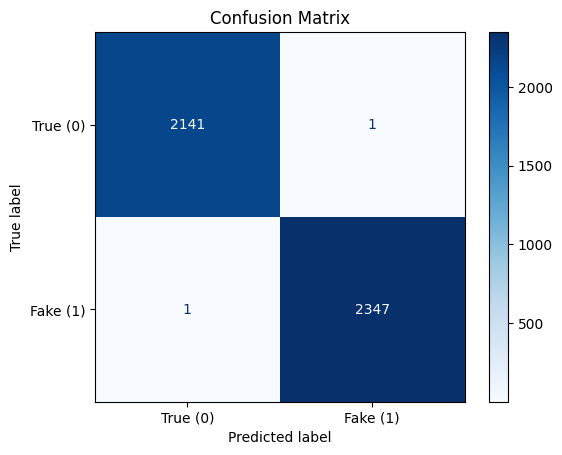

In [ ]:

test_results = trainer.evaluate(test_dataset)
print("Test Results:")
for key, value in test_results.items():
    print(f"  {key}: {value:.4f}")

predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

print("\n Confusion Matrix Analysis ")
print("Matrix (Rows=Actual, Cols=Predicted):")
print("             | Predicted 0 (True) | Predicted 1 (Fake)")
print(f"Actual 0 (True): {cm[0, 0]:<19} | {cm[0, 1]:>15}")
print(f"Actual 1 (Fake): {cm[1, 0]:<19} | {cm[1, 1]:>15}")
print("\nInterpretation:")
print(f"  True Negatives (Correct True News): {cm[0, 0]}")
print(f"  True Positives (Correct Fake News): {cm[1, 1]}")
print(f"  False Positives (Type I Error): {cm[0, 1]} (Model predicted Fake, Actual was True)")
print(f"  False Negatives (Type II Error): {cm[1, 0]} (Model predicted True, Actual was Fake)")


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['True (0)', 'Fake (1)'])
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Phase 4: SHAP

In [ ]:
def predict_fn(texts):
    if isinstance(texts, np.ndarray) or isinstance(texts, pd.Series):
        texts = texts.tolist()

    encodings = tokenizer(
        texts,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    with torch.no_grad():
        output = model(input_ids=input_ids, attention_mask=attention_mask)
    
    return output.logits.detach().cpu().numpy()[:, 1]



num_samples_for_shap = min(10, len(df_test)) 
df_shap_sample = df_test.sample(n=num_samples_for_shap, random_state=RANDOM_SEED).reset_index(drop=True)

X_explain = df_shap_sample['full_text'].to_numpy()
y_explain = df_shap_sample['label'].to_numpy() 

explainer = shap.Explainer(predict_fn, tokenizer)

print(f"Explainer initialized. Computing SHAP values for {num_samples_for_shap} samples...")

shap_values = explainer(X_explain)


print("Red words push prediction toward FAKE (1). Blue words push toward TRUE (0).")

for i in range(min(3, num_samples_for_shap)):
    print(f"\nSample {i+1}:")
    true_label = 'Fake' if y_explain[i] == 1 else 'True'
    print(f"  True Label: {true_label}")
    
    shap.plots.text(shap_values[i])
    


--- Starting SHAP Explainability Setup ---
Explainer initialized. Computing SHAP values for 10 samples...


PartitionExplainer explainer: 11it [09:02, 54.21s/it]                        

SHAP value computation complete.

--- SHAP Visualization ---
Red words push prediction toward FAKE (1). Blue words push toward TRUE (0).

Sample 1:
  True Label: Fake



Sample 2:
  True Label: Fake



Sample 3:
  True Label: Fake


Testing on different dataset

In [ ]:


print("\n[5.1] Loading new GossipCop/PolitiFact data...")

try:
    df_gc_fake = pd.read_csv('testdata/gossipcop_fake.csv')
    df_gc_real = pd.read_csv('testdata/gossipcop_real.csv')
    df_pf_fake = pd.read_csv('testdata/politifact_fake.csv')
    df_pf_real = pd.read_csv('testdata/politifact_real.csv')

    df_gc_fake['label'] = 1
    df_gc_real['label'] = 0
    df_pf_fake['label'] = 1
    df_pf_real['label'] = 0

    dfs = [df_gc_fake, df_gc_real, df_pf_fake, df_pf_real]
    
    for i, df in enumerate(dfs):
        if 'news_content' in df.columns:
            df['full_text'] = df['news_content'].fillna('')
        elif 'text' in df.columns:
            title = df['title'].fillna('') if 'title' in df.columns else ''
            text = df['text'].fillna('')
            df['full_text'] = title + " [SEP] " + text
        elif 'title' in df.columns:
            df['full_text'] = df['title'].fillna('')
        else:
            df['full_text'] = '' 

except FileNotFoundError:
    print("FATAL ERROR: GossipCop/PolitiFact CSV files not found. Please check your file paths.")
    raise

df_combined_new = pd.concat([df[['full_text', 'label']] for df in dfs], ignore_index=True)
df_combined_new.dropna(subset=['full_text'], inplace=True)
df_combined_new = df_combined_new[df_combined_new['full_text'].str.strip() != ''].reset_index(drop=True)
df_model_new = df_combined_new.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

print("[5.2] Tokenizing new data...")

X_new = df_model_new['full_text']
y_new = df_model_new['label']

test_dataset_new = FakeNewsDataset(X_new, y_new, tokenizer, MAX_LEN)

print("\n[5.3] Evaluating ORIGINAL trained model on NEW challenging dataset...")

test_results_transfer = trainer.evaluate(test_dataset_new)

print("\n TEST Results: ")
for key, value in test_results_transfer.items():
    print(f"  {key}: {value:.4f}")

print("\nInterpretation:")
print(f"  The original accuracy was 0.9996. A significant drop here (e.g., to 0.7000) confirms the model relied on stylistic markers.")




--- STARTING PHASE 5: ZERO-SHOT TRANSFER EVALUATION (FakeNewsNet) ---

[5.1] Loading new GossipCop/PolitiFact data...
[5.2] Tokenizing new data...

[5.3] Evaluating ORIGINAL trained model on NEW challenging dataset...



--- TRANSFER TEST Results (Original Model on FakeNewsNet) ---
  eval_loss: 0.6447
  eval_model_preparation_time: 0.0000
  eval_accuracy: 0.7486
  eval_f1: 0.0095
  eval_precision: 0.2105
  eval_recall: 0.0049
  eval_runtime: 2960.2245
  eval_samples_per_second: 7.8360
  eval_steps_per_second: 0.2450

Interpretation:
  The original accuracy was 0.9996. A significant drop here (e.g., to 0.7000) confirms the model relied on stylistic markers.

--- Phase 5 Complete ---


Model Tuning

In [ ]:
BERT_MODEL_NAME = 'bert-base-uncased' 
MAX_LEN = 128
RANDOM_SEED = 42
BATCH_SIZE = 16
NUM_EPOCHS = 1 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', pos_label=1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)


print("[6.0] Loading and consolidating new FakeNewsNet data...")

try:
    df_gc_fake = pd.read_csv('testdata/gossipcop_fake.csv')
    df_gc_real = pd.read_csv('testdata/gossipcop_real.csv')
    df_pf_fake = pd.read_csv('testdata/politifact_fake.csv')
    df_pf_real = pd.read_csv('testdata/politifact_real.csv')

    df_gc_fake['label'] = 1
    df_gc_real['label'] = 0
    df_pf_fake['label'] = 1
    df_pf_real['label'] = 0

    dfs = [df_gc_fake, df_gc_real, df_pf_fake, df_pf_real]
    
    for i, df in enumerate(dfs):
        if 'news_content' in df.columns:
            df['full_text'] = df['news_content'].fillna('')
        elif 'text' in df.columns:
            title = df['title'].fillna('') if 'title' in df.columns else ''
            text = df['text'].fillna('')
            df['full_text'] = title + " [SEP] " + text
        elif 'title' in df.columns:
            df['full_text'] = df['title'].fillna('')
        else:
            df['full_text'] = '' 

except FileNotFoundError:
    print("FATAL ERROR: GossipCop/PolitiFact CSV files not found. Cannot proceed.")
    raise

df_combined_new = pd.concat([df[['full_text', 'label']] for df in dfs], ignore_index=True)
df_combined_new.dropna(subset=['full_text'], inplace=True)
df_model_new = df_combined_new[df_combined_new['full_text'].str.strip() != ''].sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)


print("[6.1] Splitting and Tokenizing data for training...")

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    df_model_new['full_text'], df_model_new['label'], test_size=0.1, random_state=RANDOM_SEED, stratify=df_model_new['label']
)
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train_final, y_train_final, test_size=(1/9), random_state=RANDOM_SEED, stratify=y_train_final
)

train_dataset_final = FakeNewsDataset(X_train_final, y_train_final, tokenizer, MAX_LEN)
val_dataset_final = FakeNewsDataset(X_val_final, y_val_final, tokenizer, MAX_LEN)
test_dataset_final = FakeNewsDataset(X_test_final, y_test_final, tokenizer, MAX_LEN)


print("[6.2] Initializing NEW model and trainer...")

model_final = BertForSequenceClassification.from_pretrained(BERT_MODEL_NAME, num_labels=2)
model_final.to(device)

training_args_final = TrainingArguments(
    output_dir='./results_fakenewsnet',
    num_train_epochs=NUM_EPOCHS, 
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_fakenewsnet',
    logging_steps=100,
    eval_strategy="epoch", 
    save_strategy="epoch",
    load_best_model_at_end=True,
    seed=RANDOM_SEED,
)

trainer_final = Trainer(
    model=model_final,
    args=training_args_final,
    train_dataset=train_dataset_final,
    eval_dataset=val_dataset_final,
    compute_metrics=compute_metrics,
)



--- STARTING PHASE 6: TRAINING ON CHALLENGING DATA ---
[6.0] Loading and consolidating new FakeNewsNet data...
[6.1] Splitting and Tokenizing data for training...
[6.2] Initializing NEW model and trainer...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer_final.train()



--- STARTING PHASE 6: TRAINING ON CHALLENGING DATA ---
[6.0] Loading and consolidating new FakeNewsNet data...
[6.1] Splitting and Tokenizing data for training...
[6.2] Initializing NEW model and trainer...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Starting FINAL BERT Fine-Tuning (1 Epoch) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.367700,0.355635,0.849138,0.675325,0.725100,0.631944


--- FINAL Fine-Tuning Complete ---

[6.3] Evaluating Robust Model on its NEW Test Set...



--- ROBUST MODEL Test Results (Trained on FakeNewsNet) ---
  eval_loss: 0.3568
  eval_accuracy: 0.8612
  eval_f1: 0.7046
  eval_precision: 0.7471
  eval_recall: 0.6667
  eval_runtime: 196.7412
  eval_samples_per_second: 11.7920
  eval_steps_per_second: 0.3710
  epoch: 1.0000

--- Phase 6 Complete ---


In [ ]:

print("\n[6.3] Evaluating Robust Model on its NEW Test Set...")
test_results_final = trainer_final.evaluate(test_dataset_final)

print("\nTest Results: ")
for key, value in test_results_final.items():
    print(f"  {key}: {value:.4f}")

In [ ]:
def predict_fn_final(texts):
    if isinstance(texts, np.ndarray) or isinstance(texts, pd.Series):
        texts = texts.tolist()

    encodings = tokenizer(
        texts,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    with torch.no_grad():
        output = model_final(input_ids=input_ids, attention_mask=attention_mask)
    
    return output.logits.detach().cpu().numpy()[:, 1]


num_samples_for_shap = 10 
df_test_final_temp = pd.DataFrame({'full_text': X_test_final, 'label': y_test_final}).reset_index(drop=True)
df_shap = df_test_final_temp.sample(n=num_samples_for_shap, random_state=RANDOM_SEED)

X_explain_final = df_shap['full_text'].to_numpy()
y_explain_final = df_shap['label'].to_numpy() 

explainer_final = shap.Explainer(predict_fn_final, tokenizer)

print(f"Explainer initialized. Computing SHAP values for {num_samples_for_shap} samples...")

shap_values_final = explainer_final(X_explain_final)

print("SHAP value computation complete.")

print("\n SHAP Visualization ")
print("Red words push prediction toward FAKE (1). Blue words push toward TRUE (0).")

for i in range(min(3, num_samples_for_shap)):
    print(f"\nSample {i+1}:")
    true_label = 'Fake' if y_explain_final[i] == 1 else 'True'
    print(f"  True Label: {true_label}")
    
    shap.plots.text(shap_values_final[i])
    



--- STARTING PHASE 7: SHAP for ROBUST MODEL ---
Explainer initialized. Computing SHAP values for 10 samples...


PartitionExplainer explainer: 11it [03:45, 22.57s/it]                        

SHAP value computation complete.

--- SHAP Visualization (Robust Model) ---
Red words push prediction toward FAKE (1). Blue words push toward TRUE (0).

Sample 1:
  True Label: True



Sample 2:
  True Label: True



Sample 3:
  True Label: True
